In [1]:
# 引入一些必要的包
import seaborn as sns
import pandas as pd
import numpy as np
import os
import gc
import time
import random
import zipfile
import warnings
import lightgbm as lgb
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
from datetime import date, timedelta
from gensim.models import Word2Vec
from sklearn import linear_model
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline

# 方便展示的一些设定
warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.max_rows", 1000)
pd.set_option('display.max_colwidth', 1000)

# Settings

In [2]:
FOLD = 7             # 交叉验证的折数
SEED = 1994          # 全局随机数种子
EPOCHS = 100000      # Lgb模型的最大迭代次数
USE_LOG = True       # 是否对病例数据进行log(1+x)的变换 
WINDOW_SIZE = 14      # 从时序数据中构建特征所需的时间窗口
NUDGE_PATH = "./nudge/*.csv"  # 预测结果后处理文件
DATA_PATH = "./data/" # 比赛数据所在文件夹

# 2019年和2020年给定数据的日期
test_date_2019 = list(pd.date_range("20190201", "20190228")) + list(pd.date_range("20190501", "20190531")) + \
                 list(pd.date_range("20190801", "20190831")) + list(pd.date_range("20191101", "20191130"))
test_date_2020 = list(pd.date_range("20200301", "20200331")) + list(pd.date_range("20200601", "20200630"))

# 需要预测的日期
pred_date_2019 = list(pd.date_range("20190301", "20190314")) + list(pd.date_range("20190601", "20190614")) + \
                 list(pd.date_range("20190901", "20190914")) + list(pd.date_range("20191201", "20191214"))
pred_date_2020 = list(pd.date_range("20200401", "20200414")) + list(pd.date_range("20200701", "20200714"))

# 2019年和2020年六段给定数据中每段日期的始末
test_start = [pd.Timestamp("20190201"), pd.Timestamp("20190501"), pd.Timestamp("20190801"), 
              pd.Timestamp("20191101"), pd.Timestamp("20200301"), pd.Timestamp("20200601")]
test_end = [pd.Timestamp("20190228"), pd.Timestamp("20190531"), pd.Timestamp("20190831"), 
            pd.Timestamp("20191130"), pd.Timestamp("20200331"), pd.Timestamp("20200630")]


# 全局随机数函数
def seed_everything(seed):
    random.seed(seed)                           # Python 在一个明确的初始状态生成固定随机数字所必需的
    os.environ['PYTHONHASHSEED'] = str(seed)    # 为了使某些基于散列的操作可复现
    np.random.seed(seed)                        # numpy 在一个明确的初始状态生成固定随机数字所必需的


seed_everything(SEED)

# Prepare Dataset

In [3]:
# 读取数据
count2017 = pd.read_csv(DATA_PATH+"count_2017.csv", parse_dates=['date'])
count2018 = pd.read_csv(DATA_PATH+"count_2018.csv", parse_dates=['date'])
count2019 = pd.read_csv(DATA_PATH+"count_2019.csv", parse_dates=['date'])
count2020 = pd.read_csv(DATA_PATH+"count_2020.csv", parse_dates=['date'])
train2017 = pd.read_csv(DATA_PATH+"train_2017.csv", parse_dates=['treatment_date'])
train2018 = pd.read_csv(DATA_PATH+"train_2018.csv", parse_dates=['treatment_date'])
test2019 = pd.read_csv(DATA_PATH+"test_2019.csv", parse_dates=['treatment_date'])
test2020 = pd.read_csv(DATA_PATH+"test_2020.csv", parse_dates=['treatment_date'])
submit = pd.read_csv(DATA_PATH+"submit.csv")
to_predict = pd.read_csv(DATA_PATH+"to_predict.csv", parse_dates=['date'])

# 将数据拼接
info = pd.concat([train2017, train2018, test2019, test2020], axis=0)
count = pd.concat([count2017, count2018, count2019, count2020], axis=0)
submit = submit.join(to_predict.set_index(["id"]), on="id", how="left")
submit["count"] = np.nan
unique_ills = submit["admin_illness_name"].unique()  # 30个病种

del count2017, count2018, count2019, count2020
del train2017, train2018, test2019, test2020, to_predict
for col in ["outpatient_num", "other_card_code", "clinic_emergency_mark_code", "org_code", "district_code", "treatment_section_code"]:
    del info[col]
gc.collect()

4

In [4]:
# 将30个病种的病例数量数据按时序展开，30行对应30个病种，列对应每日病例数量
count_flat = count.set_index(["admin_illness_name", "date"])[["count"]].unstack(level=-1)
count_flat.columns = count_flat.columns.get_level_values(1)

# 对原始的病例数量数据填充缺失值为0，为后续构建相邻几日病例数量比值的时间序列做准备
count_flat_div = count_flat.copy().fillna(0)

# 对原始的病例数量数据填充缺失值为0，为后续的数据分箱、TF-IDF、NMF矩阵分解、及class特征做准备
count_flat_no_log = count_flat.copy().fillna(0).astype(np.int32) 

if USE_LOG:
    count_flat_nan = np.log1p(count_flat)
else:
    count_flat_nan = count_flat
count_flat = count_flat_nan.copy().fillna(0)
illness = count_flat.index  # 30个病种

count_flat.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
admin_illness_name                                                   
上呼吸道感染                3.931826    2.944439    3.332205    3.526361   
上呼吸道疾病                0.000000    0.000000    0.000000    0.000000   
丘疹性荨麻疹                0.000000    0.000000    0.000000    0.000000   
中耳炎                   1.386294    1.386294    1.386294    1.609438   
发热                    0.693147    2.079442    0.693147    1.609438   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
admin_illness_name                                                   
上呼吸道感染                2.833213    2.708050    3.135494    3.688879   
上呼吸道疾病                0.000000    0.000000    0.000000    0.000000   
丘疹性荨麻疹                0.000000    0.000000    0.000000    0.000000   
中耳炎                   1.386294    1.945910    0.693147    1.386294   
发热                    2.833213    0.693147    1.386294    2.079442   

date                2017-01-09  2017-01-10  ...  2020-06-21  2020-06-22  \
admin_illness_name                          ...                           
上呼吸道感染                3.295837    3.218876  ...    3.806662    4.189655   
上呼吸道疾病                0.000000    0.000000  ...    1.386294    0.000000   
丘疹性荨麻疹                0.000000    0.000000  ...    2.995732    2.833213   
中耳炎                   1.386294    1.386294  ...    1.791759    2.397895   
发热                    1.609438    1.609438  ...    4.094345    4.442651   

date                2020-06-23  2020-06-24  2020-06-25  2020-06-26  \
admin_illness_name                                                   
上呼吸道感染                3.555348    3.871201    3.583519    3.637586   
上呼吸道疾病                0.000000    0.000000    0.000000    1.098612   
丘疹性荨麻疹                3.044522    2.079442    2.564949    3.178054   
中耳炎                   1.386294    2.564949    2.197225    1.945910   
发热                    3.951244    4.043051    4.127134    4.234107   

date                2020-06-27  2020-06-28  2020-06-29  2020-06-30  
admin_illness_name                                                  
上呼吸道感染                3.761200    3.496508    3.583519    3.637586  
上呼吸道疾病                0.693147    0.693147    0.000000    1.098612  
丘疹性荨麻疹                3.178054    3.091042    2.302585    2.564949  
中耳炎                   2.302585    1.098612    2.397895    2.197225  
发热                    3.610918    4.127134    4.025352    4.356709  

[5 rows x 911 columns]

In [5]:
# 将病例数量数据按分位数分箱为0到24的某个整数值，降低数据轻微波动对embedding效果的干扰
pre_value = []
for i in range(30):
    pre_value.extend([value for value in count_flat_no_log.iloc[i].values])
_, bins = pd.qcut(pre_value, q=25, retbins=True, duplicates="drop")
aft_value, bins = pd.qcut(pre_value, labels=list(range(len(bins)-1)), q=25, retbins=True, duplicates="drop")
mapping = dict(zip(pre_value, aft_value))

# 将30个病种，每个病种的病例数量数据作为一个sentences，每日的病例数量为sentences中的word
sentences = []
for i in range(30):
    temp = count_flat_no_log.iloc[i].values
    sentences.append(" ".join([str(mapping[num]) for num in temp]))

# 使用ngram为1至3的TF-IDF算法将30个sentences转化为30个高维稀疏向量
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
tfidf = tfidf_vectorizer.fit_transform(sentences)

# 使用NMF矩阵分解算法，将每个病种的高维稀疏向量表征为一个主题数量为12的主题分布向量
topics = 12
text_nmf = NMF(n_components=topics, random_state=SEED, l1_ratio=1)
tfidf_matrix = text_nmf.fit_transform(tfidf)

# 将每个病种归类到其主题分布向量值最大的那个类别（主题）处，因此每个病种都会对应一个class
tfidf_matrix = pd.DataFrame(tfidf_matrix)
tfidf_matrix.columns = [f"nmf_{i+1}" for i in range(topics)]
tfidf_matrix["class"] = tfidf_matrix.values.argmax(axis=1) + 1
tfidf_matrix["ill"] = illness
# tfidf_matrix.groupby(["class"], as_index=False)["ill"].agg({"total": list})

# 将同一class的病种病例数量数据加和，形成一个class对应的病例数量时间序列数据
count_class = count.copy()
ill_class_mapping = dict(zip(tfidf_matrix["ill"], tfidf_matrix["class"]))
count_class["class"] = count_class["admin_illness_name"].map(lambda x: ill_class_mapping[x])
count_class = count_class.groupby(["class", "date"])["count"].sum().reset_index()
count_class = count_class.set_index(["class", "date"])[["count"]].unstack(level=-1).fillna(0)
count_class.columns = count_class.columns.get_level_values(1)
if USE_LOG:
    count_class = np.log1p(count_class)
    
count_class

date   2017-01-01  2017-01-02  2017-01-03  2017-01-04  2017-01-05  2017-01-06  \
class                                                                           
1        2.708050    2.079442    2.708050    1.609438    2.302585    2.890372   
2        4.094345    3.663562    3.828641    4.204693    3.637586    3.713572   
3        3.044522    3.218876    3.295837    3.496508    3.496508    3.610918   
4        0.000000    1.386294    1.791759    1.945910    1.386294    1.945910   
5        3.688879    3.891820    3.663562    4.007333    4.394449    3.970292   
6        1.386294    2.302585    1.098612    1.945910    1.791759    1.098612   
7        1.386294    1.386294    1.386294    1.791759    1.791759    1.945910   
8        0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
9        2.995732    3.178054    3.178054    3.258097    2.079442    2.833213   
10       0.000000    1.098612    0.000000    0.693147    1.098612    0.000000   
11       2.708050    2.833213    2.302585    2.944439    3.178054    3.178054   
12       2.079442    2.944439    3.332205    3.091042    3.091042    1.386294   

date   2017-01-07  2017-01-08  2017-01-09  2017-01-10  ...  2020-06-21  \
class                                                  ...               
1        1.945910    1.386294    2.397895    2.639057  ...    3.583519   
2        3.637586    4.094345    4.143135    3.871201  ...    5.720312   
3        2.772589    2.484907    3.688879    3.433987  ...    4.488636   
4        0.000000    0.693147    1.609438    1.386294  ...    4.330733   
5        3.737670    3.663562    4.094345    3.871201  ...    5.293305   
6        1.791759    2.197225    2.079442    1.609438  ...    4.043051   
7        1.098612    1.386294    1.609438    1.386294  ...    4.234107   
8        0.000000    0.000000    0.000000    0.000000  ...    3.850148   
9        2.302585    3.526361    2.708050    3.135494  ...    3.951244   
10       1.386294    0.000000    0.000000    0.000000  ...    2.564949   
11       2.639057    2.302585    3.044522    3.433987  ...    3.663562   
12       2.890372    1.609438    2.484907    1.791759  ...    4.394449   

date   2020-06-22  2020-06-23  2020-06-24  2020-06-25  2020-06-26  2020-06-27  \
class                                                                           
1        3.737670    3.526361    3.258097    3.583519    3.663562    3.258097   
2        5.877736    5.627621    5.693732    5.602119    5.616771    5.620401   
3        4.304065    4.369448    4.077537    4.110874    3.891820    4.276666   
4        3.610918    4.248495    4.043051    4.219508    4.025352    4.204693   
5        5.267858    5.068904    5.075174    5.068904    5.273000    5.068904   
6        4.143135    4.127134    3.988984    4.025352    4.304065    4.290459   
7        4.430817    4.317488    4.330733    4.077537    4.442651    4.499810   
8        3.295837    3.583519    3.135494    3.610918    3.637586    3.784190   
9        4.007333    3.637586    3.850148    4.234107    4.025352    3.850148   
10       2.772589    2.397895    2.639057    2.302585    2.564949    1.791759   
11       3.583519    3.401197    3.784190    3.258097    3.433987    3.295837   
12       3.367296    4.043051    3.496508    3.737670    2.890372    2.639057   

date   2020-06-28  2020-06-29  2020-06-30  
class                                      
1        3.091042    3.784190    3.850148  
2        5.446737    5.645447    5.560682  
3        4.356709    4.304065    4.043051  
4        3.871201    3.258097    4.060443  
5        4.927254    4.969813    5.164786  
6        3.931826    3.970292    3.761200  
7        4.343805    4.317488    4.110874  
8        2.995732    2.890372    2.833213  
9        4.143135    4.248495    3.784190  
10       1.609438    1.386294    0.693147  
11       3.583519    3.218876    3.091042  
12       3.850148    3.688879    2.995732  

[12 rows x 911 columns]

In [6]:
# 给定时间序列上第i天的病例数量a，第i+1天的病例数量b，第i+2天的病例数量c
# 则新构建的比值时间序列上第i+2天的值为transform(a, b, c)
def transform(a, b, c):
    if a == 0 and b == 0 and c == 0:
        return 1
    elif a == 0 and b == 0 and c != 0:
        return 1
    else:
        return 2 * c / (a + b)

# 根据transform函数设定的规则构建比值时间序列,该序列上每个值都是根据前两天及当天的病例数量数据计算出来的
for ill in unique_ills:
    seq = count_flat_div.loc[ill]
    for i in range(5, -1, -1):
        for date in pd.date_range(start=test_start[i]+timedelta(days=2), end=test_end[i])[::-1]:
            count_flat_div.loc[ill, date] = transform(seq[date-timedelta(days=2)], seq[date-timedelta(days=1)], seq[date])
    for date in pd.date_range("20170103", "20181231")[::-1]:
        count_flat_div.loc[ill, date] = transform(seq[date-timedelta(days=2)], seq[date-timedelta(days=1)], seq[date])

count_flat_div.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
admin_illness_name                                                   
上呼吸道感染                    50.0        18.0    0.794118    1.466667   
上呼吸道疾病                     0.0         0.0    1.000000    1.000000   
丘疹性荨麻疹                     0.0         0.0    1.000000    1.000000   
中耳炎                        3.0         3.0    1.000000    1.333333   
发热                         1.0         7.0    0.250000    1.000000   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
admin_illness_name                                                   
上呼吸道感染                0.533333    0.571429    1.466667    2.166667   
上呼吸道疾病                1.000000    1.000000    1.000000    1.000000   
丘疹性荨麻疹                1.000000    1.000000    1.000000    1.000000   
中耳炎                   0.857143    1.714286    0.222222    0.857143   
发热                    6.400000    0.100000    0.352941    3.500000   

date                2017-01-09  2017-01-10  ...  2020-06-21  2020-06-22  \
admin_illness_name                          ...                           
上呼吸道感染                0.852459    0.738462  ...    0.778761    1.287129   
上呼吸道疾病                1.000000    1.000000  ...    3.000000    0.000000   
丘疹性荨麻疹                1.000000    1.000000  ...    1.187500    0.864865   
中耳炎                   1.500000    1.000000  ...    0.909091    1.666667   
发热                    0.800000    0.727273  ...    1.008547    1.570093   

date                2020-06-23  2020-06-24  2020-06-25  2020-06-26  \
admin_illness_name                                                   
上呼吸道感染                0.623853    0.949495    0.864198    0.902439   
上呼吸道疾病                0.000000    1.000000    1.000000    1.000000   
丘疹性荨麻疹                1.142857    0.388889    0.888889    2.421053   
中耳炎                   0.400000    1.846154    1.066667    0.600000   
发热                    0.713287    0.829630    1.140187    1.162393   

date                2020-06-27  2020-06-28  2020-06-29  2020-06-30  
admin_illness_name                                                  
上呼吸道感染                1.166667    0.810127    0.945946    1.104478  
上呼吸道疾病                1.000000    0.666667    0.000000    4.000000  
丘疹性荨麻疹                1.314286    0.913043    0.409091    0.800000  
中耳炎                   1.285714    0.266667    1.818182    1.333333  
发热                    0.558140    1.173077    1.134021    1.327586  

[5 rows x 911 columns]

In [7]:
# 取dataframe中对应时间段的数据
def get_timespan(df, start_time, delta_time, periods, freq='D'):
    return df[pd.date_range(start_time-timedelta(days=delta_time), periods=periods, freq=freq)]


# 连乘函数
def continus_multiply(col):
    res = 1
    for item in col:
        res *= item
    return res


# 给定时间段来构建数据集的特征及标签
def prepare_dataset(df, start_date, target_date, isTrain=True):
    X = pd.DataFrame({})
    X_class = pd.DataFrame({})
    
    list1 = [3, 5, 7, 10, 14]
    list2 = [2]
    list3 = [3, 5, 7]
    list4 = range(1, 6)
    list5 = [2, 4, 6, 8, 12]
    
    if len(df) == 4:
        X["class"] = [ill_class_mapping[ill] for ill in unique_ills[[0, 7, 10, 11]]]
    else:
        X["class"] = tfidf_matrix["class"]
    X_class["class"] = count_class.index
    
    # 过去window天病例数量的mean、mad、min等统计量
    for window in list1:
        X[f"{window}D_mean"] = get_timespan(df, start_date, window, window).mean(axis=1).values
#         X[f"{window}D_var"] = get_timespan(df, start_date, window, window).var(axis=1).values
        X[f"{window}D_mad"] = get_timespan(df, start_date, window, window).mad(axis=1).values
#         X[f"{window}D_skew"] = get_timespan(df, start_date, window, window).skew(axis=1).values
#         X[f"{window}D_kurt"] = get_timespan(df, start_date, window, window).kurt(axis=1).values
        X[f"{window}D_min"] = get_timespan(df, start_date, window, window).min(axis=1).values
        X[f"{window}D_q20"] = get_timespan(df, start_date, window, window).quantile(0.2, axis=1).values
        X[f"{window}D_q40"] = get_timespan(df, start_date, window, window).quantile(0.4, axis=1).values
        X[f"{window}D_median"] = get_timespan(df, start_date, window, window).median(axis=1).values
        X[f"{window}D_q60"] = get_timespan(df, start_date, window, window).quantile(0.6, axis=1).values
        X[f"{window}D_q80"] = get_timespan(df, start_date, window, window).quantile(0.8, axis=1).values
        X[f"{window}D_max"] = get_timespan(df, start_date, window, window).max(axis=1).values
        X[f"{window}D_num_zero"] = (get_timespan(df, start_date, window, window)==0).sum(axis=1).values
        
        X[f"{window}D_ma_mean"] = (get_timespan(df, start_date, window, window) * np.power(0.95, np.arange(window)[::-1])).mean(axis=1).values
        if window <= 7:
            X[f"{window}D_ma_mean_1WBefore"] = (get_timespan(df, start_date-timedelta(days=7), window, window) * np.power(0.95, np.arange(window)[::-1])).mean(axis=1).values
    
    # 过去window天同一class疾病病例数量加和的mean、min、median、max
    for window in list5:
        X_class[f"{window}D_class_mean"] = get_timespan(count_class, start_date, window, window).mean(axis=1).values
        X_class[f"{window}D_class_min"] = get_timespan(count_class, start_date, window, window).min(axis=1).values
        X_class[f"{window}D_class_median"] = get_timespan(count_class, start_date, window, window).median(axis=1).values
        X_class[f"{window}D_class_max"] = get_timespan(count_class, start_date, window, window).max(axis=1).values
       
    # 过去window天比值时间序列的均值、加权连乘
    if len(df) == 4:
        temp = count_flat_div.iloc[[0, 7, 10, 11]]
    else:
        temp = count_flat_div
    for window in [2, 4, 6, 8, 12]: 
        X[f"{window}D_div_mean"] = get_timespan(temp, start_date, window, window).mean(axis=1).values
        X[f"{window}D_div_multiply"] = (get_timespan(temp, start_date, window, window) * np.power(0.9, np.arange(window)[::-1])).apply(continus_multiply, axis=1).values
    
    # 过去i天比值时间序列的值
    for i in range(1, WINDOW_SIZE-1):
        X[f"{i}D_div_value"] = temp[start_date-timedelta(days=i)].values
    
    for window in list2:
        X[f'past_{window}W_mean'] = get_timespan(df, start_date, window*7, window, freq='7D').mean(axis=1).values
        X[f'past_{window}W_var'] = get_timespan(df, start_date, window*7, window, freq='7D').var(axis=1).values
    
    # 过去i天里病例数量的值
    for i in range(1, WINDOW_SIZE+1):
        X[f"{i}D_value"] = df[start_date-timedelta(days=i)].values
        
    # 过去i天里相邻两天差值的均值、方差
    for i in list3:
        record = np.zeros((len(df), i))
        for j in range(1, i+1):
            record[:, j-1] = df[start_date-timedelta(days=j)].values - df[start_date-timedelta(days=j+1)].values
        X[f"past_{i}D_gap_mean"] = np.mean(record, axis=1)
        X[f"past_{i}D_gap_var"] = np.var(record, axis=1)
    for i in list4:
        X[f"past_No.{i}D_gap"] = df[start_date-timedelta(days=i)].values - df[start_date-timedelta(days=i+1)].values
    
    # 病种编号
    if len(df) == 4:
        X["ill"] = [0, 7, 10, 11]
    else:
        X["ill"] = [i for i in range(30)]
    
    # 时间特征
    last_day = start_date - timedelta(days=1)
    X["day_in_week"] = last_day.dayofweek
    X["day_in_month"] = last_day.day
    X["day_in_year"] = last_day.dayofyear
    X["week_in_year"] = last_day.weekofyear
    
    X = X.join(X_class.set_index(["class"]), on="class", how="left")
    X.drop(["class"], axis=1, inplace=True)

    if isTrain:
        y = df[target_date].values
        return X, pd.Series([target_date for i in range(len(df))]), y
    
    return X, pd.Series([target_date for i in range(len(df))])

# Training

In [8]:
# 构建训练集和测试集
def generate_dateset(j):
    assert 0 <= j <= 13, "J IS WRONG!"
    candidate_dates = pd.date_range(start=pd.Timestamp(2017, 11, 1)+timedelta(days=WINDOW_SIZE), end=pd.Timestamp(2018, 12, 31)-timedelta(days=j), freq="D")
    X_train = pd.DataFrame({})
    date_train = pd.Series()
    Y_train = np.empty((0, ))
    X_test = pd.DataFrame({})
    date_test = pd.Series()
    
    # 所有病种基于2017.11.1-2018.12.31构建数据
    for start_date in candidate_dates:
        curX, curDate, curY = prepare_dataset(count_flat, start_date, start_date+timedelta(days=j))
        X_train = X_train.append(curX, ignore_index=True)
        date_train = date_train.append(curDate, ignore_index=True)
        Y_train = np.concatenate((Y_train, curY))
    
    # [0, 7, 10, 11]四个病种基于2017.1.1-2017.11.1构建数据
    for start_date in pd.date_range(start=pd.Timestamp(2017, 1, 1)+timedelta(days=WINDOW_SIZE), end=pd.Timestamp(2017, 11, 1)+timedelta(days=WINDOW_SIZE-1)):
        curX, curDate, curY = prepare_dataset(count_flat.iloc[[0, 7, 10, 11]], start_date, start_date+timedelta(days=j))
        X_train = X_train.append(curX, ignore_index=True)
        date_train = date_train.append(curDate, ignore_index=True)
        Y_train = np.concatenate((Y_train, curY))
        
    for i in range(6):
        # 把2019年和2020官方提供的病例数据用上
        for start_date in pd.date_range(start=test_start[i]+timedelta(days=WINDOW_SIZE), end=test_end[i]-timedelta(days=j), freq="D"):
            curX, curDate, curY = prepare_dataset(count_flat, start_date, start_date+timedelta(days=j))
            X_train = X_train.append(curX, ignore_index=True)
            date_train = date_train.append(curDate, ignore_index=True)
            Y_train = np.concatenate((Y_train, curY))
        
        # 构建测试集
        if test_end[i] + timedelta(days=1-j-WINDOW_SIZE) < test_start[i]:
            s = test_start[i] + timedelta(days=WINDOW_SIZE)
        else:
            s = test_end[i] + timedelta(days=1-j)
        for start_date in pd.date_range(start=s, end=test_end[i]+timedelta(days=1)):
            curX, curDate = prepare_dataset(count_flat, start_date, start_date+timedelta(days=j), isTrain=False)
            X_test = X_test.append(curX, ignore_index=True)
            date_test = date_test.append(curDate, ignore_index=True)
        
    print("\n\nThis is No.{0} day Modelling.  X_Train.shape: {1},  X_test.shape: {2}".format(j+1, X_train.shape, X_test.shape))
    
    return X_train, date_train, Y_train, X_test, date_test

In [9]:
%%time

max_num = max(count["count"])
if USE_LOG:
    max_num = np.log1p(max_num)
    
train_scores_14_days = [0 for i in range(14)]
valid_scores_14_days = [0 for i in range(14)]
amounts = [0 for i in range(14)]
ols_pred = np.full([30, (pd.Timestamp(2020, 7, 14)-pd.Timestamp(2017,1,1)).days+1, 14], np.nan)
ols_true = np.full([30, (pd.Timestamp(2020, 7, 14)-pd.Timestamp(2017,1,1)).days+1], np.nan)
ols_true[:, (pd.Series(list(pd.date_range("20170101", "20181231"))+test_date_2019+test_date_2020)-pd.Timestamp(2017, 1, 1)).dt.days.values] = count_flat.values
feature_importance_df = pd.DataFrame()

# 对测试集中需要预测的14天，每天分别构建数据建模并预测
for j in range(14):
    # 生成预测第j天所需的模型训练数据和测试数据
    X_train, date_train, Y_train, X_test, date_test = generate_dateset(j)
    amounts[j] = len(X_train)
    
    # 将训练数据拆分为七份，其中六份用于训练，一份用于验证
    pred = np.zeros((len(X_test), ))
    splits = []
    kf = StratifiedKFold(FOLD, shuffle=True, random_state=SEED)
    for fold, (xx, yy) in enumerate(kf.split(X_train, X_train["ill"].values), start=1):
        splits.append((fold, xx, yy))

    for fold, xx, yy in splits:
        print(f"=======================================Fold:{fold}=======================================")
        seed_everything(SEED+fold)
        x_train = X_train.iloc[xx]
        fold_date = date_train.iloc[xx]
        y_train = Y_train[xx]
        x_valid = X_train.iloc[yy]
        oof_date = date_train.iloc[yy]
        y_valid = Y_train[yy]
        
        params = {
            'num_leaves': 32,
        #     'max_depth': 7,
            'feature_fraction': 0.8,
            'learning_rate': 0.01,
            'objective': 'mse',
            'metric': 'mse',
            'lambda_l1': 0.5,
        #     'max_bin': 500,
            'seed': SEED + fold,
        }

        dtrain = lgb.Dataset(x_train, label=y_train)
        dval = lgb.Dataset(x_valid, label=y_valid, reference=dtrain)
        lgb_model = lgb.train(params, dtrain, num_boost_round=EPOCHS, valid_sets=[dtrain, dval], 
                              early_stopping_rounds=200, verbose_eval=1000, categorical_feature=["ill"],
                             )
        
        pred += np.clip(lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration or EPOCHS), 0, max_num) / FOLD
        pred_train = np.clip(lgb_model.predict(x_train, num_iteration=lgb_model.best_iteration or EPOCHS), 0, max_num)
        pred_valid = np.clip(lgb_model.predict(x_valid, num_iteration=lgb_model.best_iteration or EPOCHS), 0, max_num)
        
        if USE_LOG:
            cur_train_mse = mean_squared_error(np.expm1(y_train), np.expm1(pred_train))
            cur_valid_mse = mean_squared_error(np.expm1(y_valid), np.expm1(pred_valid))
        else:
            cur_train_mse = mean_squared_error(y_train, pred_train)
            cur_valid_mse = mean_squared_error(y_valid, pred_valid)

        # 特征重要性统计
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = list(lgb_model.feature_name())
        fold_importance_df["importance"] = lgb_model.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = j * 10 + fold
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        train_scores_14_days[j] += cur_train_mse / FOLD
        valid_scores_14_days[j] += cur_valid_mse / FOLD
        
        ols_pred[x_valid["ill"].values, (oof_date-pd.Timestamp(2017, 1, 1)).dt.days.values, j] = pred_valid

    ols_pred[X_test["ill"].values, (date_test-pd.Timestamp(2017, 1, 1)).dt.days.values, j] = pred

# 最终总的train_mse和valid_mse
print("\nFinal Train Mse: {0:.4f}  Valid Mse: {1:.4f}".format(
    np.sum([train_scores_14_days[i]*amounts[i] for i in range(14)])/np.sum(amounts), 
    np.sum([valid_scores_14_days[i]*amounts[i] for i in range(14)])/np.sum(amounts)
))

# 14天对应的14个模型，每个模型的train_mse和valid_mse
for i in range(14):
    print("No: {0} day  Train Mse: {1:.4f}  Valid Mse: {2:.4f}".format(i+1, train_scores_14_days[i], valid_scores_14_days[i]))
np.save("ols_pred", ols_pred)



This is No.1 day Modelling.  X_Train.shape: (16486, 132),  X_test.shape: (180, 132)
=======================================Fold:1=======================================
Training until validation scores don't improve for 200 rounds
[1000]	training's l2: 0.0641842	valid_1's l2: 0.126677
Early stopping, best iteration is:
[1305]	training's l2: 0.0559887	valid_1's l2: 0.126237
=======================================Fold:2=======================================
Training until validation scores don't improve for 200 rounds
[1000]	training's l2: 0.0650919	valid_1's l2: 0.119179
[2000]	training's l2: 0.0428628	valid_1's l2: 0.117995
Early stopping, best iteration is:
[1918]	training's l2: 0.0442611	valid_1's l2: 0.117912
=======================================Fold:3=======================================
Training until validation scores don't improve for 200 rounds
[1000]	training's l2: 0.0647968	valid_1's l2: 0.121229
[2000]	training's l2: 0.0427178	valid_1's l2: 0.119954
Early stopping, be

# Score

In [10]:
feature_importance = feature_importance_df.groupby(["feature"], as_index=False)["importance"].mean().sort_values(by=["importance"], ascending=False).reset_index(drop=True)
feature_importance["importance"] = np.round(feature_importance["importance"], 1)
feature_importance

feature  importance
0                7D_mean     78306.6
1             5D_ma_mean     66474.2
2             7D_ma_mean     65205.0
3            10D_ma_mean     62829.7
4                 5D_q20     37745.9
5                5D_mean     32759.8
6             3D_ma_mean     30338.6
7                 5D_q40     24912.5
8                3D_mean     23096.2
9            14D_ma_mean     22083.6
10                7D_q40     21013.0
11              1D_value     20716.3
12                3D_q20     17854.8
13                7D_q60     17823.5
14                3D_q80     13602.6
15              10D_mean     12433.9
16             5D_median     12393.0
17                3D_q40     11963.6
18                5D_max      9712.8
19                   ill      9283.0
20                3D_max      8976.9
21                5D_q60      8701.6
22                5D_q80      7502.7
23          past_2W_mean      7316.9
24              14D_mean      7208.3
25                7D_q20      6824.3
26              2D_value      6692.4
27              3D_value      6640.8
28                3D_q60      6030.9
29                7D_max      5832.3
30               10D_min      5815.6
31           day_in_year      5706.7
32             3D_median      5581.9
33              4D_value      5580.9
34                7D_q80      4676.0
35               10D_q20      4409.1
36              5D_value      3969.6
37               14D_q40      3422.9
38               14D_min      3286.7
39              6D_value      3277.1
40               10D_q60      2984.1
41                7D_min      2933.2
42             7D_median      2443.0
43            10D_median      2290.8
44               10D_max      2259.1
45             11D_value      2206.5
46               14D_q20      2191.7
47              8D_value      2189.6
48             13D_value      1950.9
49               10D_q40      1936.3
50             10D_value      1933.6
51             12D_value      1898.6
52                3D_min      1754.9
53              9D_value      1729.7
54                5D_min      1562.3
55               10D_q80      1468.7
56         11D_div_value      1313.7
57          12D_div_mean      1292.7
58              7D_value      1280.3
59         12D_div_value      1276.7
60          9D_div_value      1260.7
61               14D_max      1254.8
62           day_in_week      1225.7
63         10D_div_value      1182.0
64          8D_div_value      1170.0
65          week_in_year      1118.8
66          7D_div_value      1059.2
67               14D_mad      1054.6
68          6D_div_value      1033.7
69           past_2W_var      1000.4
70      12D_div_multiply       989.5
71      past_7D_gap_mean       976.0
72          day_in_month       971.0
73            14D_median       962.6
74           8D_div_mean       947.8
75        past_No.5D_gap       942.0
76       8D_div_multiply       930.8
77       past_7D_gap_var       929.6
78        past_No.4D_gap       924.8
79             14D_value       900.1
80               10D_mad       886.2
81      past_5D_gap_mean       885.9
82          4D_div_value       860.5
83          5D_div_value       859.2
84       6D_div_multiply       848.0
85       4D_div_multiply       843.0
86        past_No.3D_gap       839.5
87      past_3D_gap_mean       825.6
88               14D_q80       817.7
89        past_No.2D_gap       815.3
90        past_No.1D_gap       813.0
91          3D_div_value       808.5
92           6D_div_mean       797.9
93         12D_class_max       797.3
94         12D_class_min       780.7
95          2D_div_value       774.3
96       past_3D_gap_var       773.9
97                7D_mad       754.4
98           2D_div_mean       745.6
99       past_5D_gap_var       743.4
100         1D_div_value       740.8
101          4D_div_mean       737.0
102              14D_q60       714.9
103      2D_div_multiply       675.7
104               3D_mad       675.3
105               5D_mad       650.9
106         2D_class_max       577.5
107  3D_ma_mean_1WBef

# Plot

In [11]:
# 将30个病种，每个病种2017年、2018年、2019年、2020年的病例数据绘制出来
# 绿色为官方给定的病例数据，红色为模型预测的病例数据
def plot_trend(suffix):
    final_count = pd.concat([count, submit[["admin_illness_name", "date", "count"]]], axis=0)
    count_flat_plot = final_count.set_index(["admin_illness_name", "date"])[["count"]].unstack(level=-1)
    count_flat_plot.columns = count_flat_plot.columns.get_level_values(1)

    fig, ax = plt.subplots(120, 1, figsize=(20, 600))

    for i, ill in enumerate(illness):
        ts_all = count_flat_plot.loc[ill]
        max_value = ts_all.max()
        ts_2017 = count_flat_plot.loc[ill, pd.date_range("20170101", "20171231")]
        ts_2018 = count_flat_plot.loc[ill, pd.date_range("20180101", "20181231")]
        ts_2019 = count_flat_plot.loc[ill, test_date_2019]
        ts_2020 = count_flat_plot.loc[ill, test_date_2020]
        ts_2019_pred = count_flat_plot.loc[ill, pred_date_2019]
        ts_2020_pred = count_flat_plot.loc[ill, pred_date_2020]
        nan_all = sum(ts_all.isnull())
        nan_2017 = sum(ts_2017.isnull())
        nan_2018 = sum(ts_2018.isnull())
        nan_2019 = sum(ts_2019.isnull())
        nan_2020 = sum(ts_2020.isnull())
        zero_all = sum(ts_all==0)
        zero_2017 = sum(ts_2017==0)
        zero_2018 = sum(ts_2018==0)
        zero_2019 = sum(ts_2019==0)
        zero_2020 = sum(ts_2020==0)

        _ = ax[4*i].plot(ts_2017, "go-")
        _ = ax[4*i].set_xticks([pd.Timestamp(2017,1,1), pd.Timestamp(2017,3,1), pd.Timestamp(2017,5,1), 
                                pd.Timestamp(2017,7,1), pd.Timestamp(2017,9,1), pd.Timestamp(2017,11,1), pd.Timestamp(2017,12,31)])
        _ = ax[4*i].set_xlim(xmin=pd.Timestamp(2016, 12, 25), xmax=pd.Timestamp(2018, 1, 5))
        _ = ax[4*i].set_ylim(ymin=0, ymax=max_value)
        _ = ax[4*i].set_title(u"{0}_2017,  NaN: {1}/{2},  Zero: {3}/{4}".format(i, nan_2017, nan_all, zero_2017, zero_all))
        _ = ax[4*i].grid(axis='y')


        _ = ax[4*i+1].plot(ts_2018, "go-")
        _ = ax[4*i+1].set_xticks([pd.Timestamp(2018,1,1), pd.Timestamp(2018,3,1), pd.Timestamp(2018,5,1), 
                                  pd.Timestamp(2018,7,1), pd.Timestamp(2018,9,1), pd.Timestamp(2018,11,1), pd.Timestamp(2018,12,31)])
        _ = ax[4*i+1].set_xlim(xmin=pd.Timestamp(2017, 12, 25), xmax=pd.Timestamp(2019, 1, 5))
        _ = ax[4*i+1].set_ylim(ymin=0, ymax=max_value)
        _ = ax[4*i+1].set_title(u"{0}_2018,  NaN: {1}/{2},  Zero: {3}/{4}".format(i, nan_2018, nan_all, zero_2018, zero_all))
        _ = ax[4*i+1].grid(axis='y')


        _ = ax[4*i+2].plot(ts_2019, "go-")
        for j in range(4):
            _ = ax[4*i+2].plot(ts_2019_pred[j:(j+1)*14], "ro-")
        _ = ax[4*i+2].set_xticks([pd.Timestamp(2019,1,1), pd.Timestamp(2019,3,1), pd.Timestamp(2019,5,1), 
                                  pd.Timestamp(2019,7,1), pd.Timestamp(2019,9,1), pd.Timestamp(2019,11,1), pd.Timestamp(2019,12,31)])
        _ = ax[4*i+2].set_xlim(xmin=pd.Timestamp(2018, 12, 25), xmax=pd.Timestamp(2020, 1, 5))
        _ = ax[4*i+2].set_ylim(ymin=0, ymax=max_value)
        _ = ax[4*i+2].set_title(u"{0}_2019,  NaN: {1}/{2},  Zero: {3}/{4}".format(i, nan_2019, nan_all, zero_2019, zero_all))
        _ = ax[4*i+2].grid(axis='y')


        _ = ax[4*i+3].plot(ts_2020, "go-")
        for j in range(4):
            _ = ax[4*i+3].plot(ts_2020_pred[j:(j+1)*14], "ro-")
        _ = ax[4*i+3].set_xticks([pd.Timestamp(2020,1,1), pd.Timestamp(2020,3,1), pd.Timestamp(2020,5,1), 
                                  pd.Timestamp(2020,7,1), pd.Timestamp(2020,9,1), pd.Timestamp(2020,11,1), pd.Timestamp(2020,12,31)])
        _ = ax[4*i+3].set_xlim(xmin=pd.Timestamp(2019, 12, 25), xmax=pd.Timestamp(2021, 1, 5))
        _ = ax[4*i+3].set_ylim(ymin=0, ymax=max_value)
        _ = ax[4*i+3].set_title(u"{0}_2020,  NaN: {1}/{2},  Zero: {3}/{4}".format(i, nan_2020, nan_all, zero_2020, zero_all))
        _ = ax[4*i+3].grid(axis='y')

# PostProcess & Submit

In [12]:
submit["count"] = np.nan

# 提取出最终的预测结果
for i in range(30):
    for j in range(6):
        for k in range(1, 15):
            t = test_end[j] + timedelta(days=15-k)
            submit.loc[(submit["date"]==t) & (submit["admin_illness_name"]==illness[i]), "count"] = ols_pred[i, (t-pd.Timestamp(2017, 1, 1)).days, 14-k]

# 将预测结果进行log(1+x)的反变换
if USE_LOG:
    submit["count"] = np.expm1(submit["count"])
    
submit.loc[submit["date"].isin(pd.date_range("20200101", "20201231")), "count"] *= 0.92

# 读取后处理所需的辅助文件
final = submit[["id", "count"]]
compare = final.copy()
for idx, item in enumerate(glob(NUDGE_PATH)):  # 86个
    compare["count"+str(idx)] = pd.read_csv(item)["count"]
compare.drop(["id", "count"], axis=1, inplace=True)

# 后处理
for i in range(len(final)):
    if sum(final.loc[i, "count"] > compare.loc[i]) > 83:
        final.loc[i, "count"] *= 1.005
    elif sum(final.loc[i, "count"] < compare.loc[i]) > 83:
        final.loc[i, "count"] *= 0.995
        
final.to_csv("HideOnBush.csv", index=False)

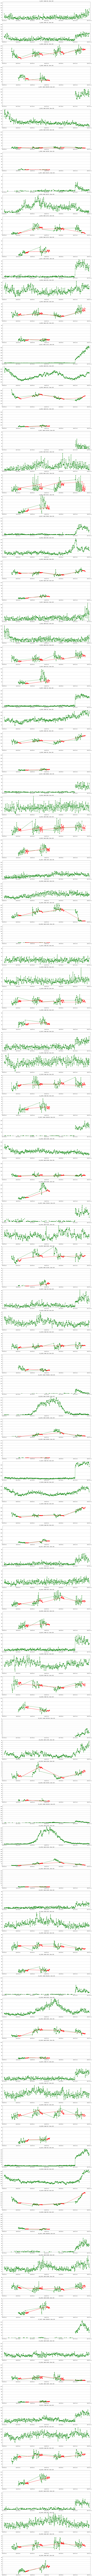

In [13]:
# 将30个病种，每个病种2017年、2018年、2019年、2020年的病例数据绘制出来
# 绿色为官方给定的病例数据，红色为模型预测的病例数据
plot_trend("latest")